## **Data Challenge - Diversity in the Workplace**

**Challenge Description**

There has been lots of talking about diversity in the workplace, especially in technology. The Head of HR at your company is very concerned about that and has asked you to analyze internal data about employees and see whether results suggest that the company is treating its employees fairly.

**Question 1**

In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.

Individual Contributors (IC) - they don't manage anyone

Middle Managers (MM) - they are the direct bosses of IC

Directors (D) - they are the direct bosses of MM

VP - D direct bosses

Executives (E) - VP direct bosses

CEO - The direct boss of E.


**Question 2**

How many people each employee manages? You should have a table with employee ids and the number of people managed. 

Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.


**Question 3**

Build a model to predict the salary of each employee.

**Question 4**

Describe the main factors impacting employee salaries.

Do you think the company has been treating its employees fairly? Do you see any bias?

What are the next steps you would suggest to the Head of HR?

Now, let us start with the analysis.


In [0]:
#importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

Let's now import the datasets company_hierarchy.csv and employee.csv that are available for the data challenge.

In [3]:
from google.colab import files
uploaded = files.upload()

Saving company_hierarchy.csv to company_hierarchy.csv


In [0]:
company_hierarchy = pd.read_csv('company_hierarchy.csv')

In [5]:
from google.colab import files
uploaded = files.upload()

Saving employee.csv to employee.csv


In [0]:
employee = pd.read_csv('employee.csv')

In [7]:
employee.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


In [8]:
company_hierarchy.head()

,employee_id,boss_id,dept
0,46456,175361.0,sales
1,104708,29733.0,HR
2,120853,41991.0,sales
3,142630,171266.0,HR
4,72711,198240.0,sales


Let's merge both the data sets to have all the data on 1 dataframe for our analysis.

In [0]:
#merging the 2 datasets

employee = employee.merge(company_hierarchy, on = 'employee_id')

In [10]:
employee.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept
0,138719,0,273000.0,Master,M,2,43602.0,engineering
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales
2,114657,0,261000.0,Master,F,2,180854.0,sales
3,29039,0,86000.0,High_School,F,4,88370.0,HR
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales


Let's make a new column by populating null values. We have to use oyur current data to get the **designation** for each employee.

In [0]:
employee['designation']=np.nan

In [12]:
employee.isnull().sum()

employee_id           0
signing_bonus         0
salary                0
degree_level          0
sex                   0
yrs_experience        0
boss_id               1
dept                  0
designation       10000
dtype: int64

1 boss_id is NULL. This is the **CEO** who is the top most person in the organisation's hierarchy and therefore he doesn't have a boss.

In [0]:
def clean_id(x):
    try:
        return int(x)
    except:
        return np.nan

In [14]:
employee['boss_id'] = employee['boss_id'].apply(clean_id)
employee.dtypes

employee_id         int64
signing_bonus       int64
salary            float64
degree_level       object
sex                object
yrs_experience      int64
boss_id           float64
dept               object
designation       float64
dtype: object



**Solution 1**

Now, lets write a code snippet for populating the designation column using the employee_id and boss_id information that we have. We will use the **bottoms up** approach since we have got the **employee_id** of the **CEO**.

In [0]:
employee.loc[employee[employee['boss_id'].isnull()].index,'designation'] = 'CEO'

list_designations = ['CEO', 'E', 'VP', 'D', 'MM', 'IC']

i = 0
for dn in list_designations:
  if i == 5:
    break
  dn_id = list(employee[employee['designation'] == list_designations[i]].employee_id)
  for id in dn_id:
    indices = employee.index[employee['boss_id']==id]
    employee.loc[indices, 'designation']=list_designations[i+1]
  i = i+1

In [16]:
employee['designation'].value_counts()

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: designation, dtype: int64

There are 9000 ICs, 800 MM, 160 D, 35 VPs, 4 Es and 1 CEO in the dataset.

In [17]:
employee.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,designation
0,138719,0,273000.0,Master,M,2,43602.0,engineering,IC
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales,IC
2,114657,0,261000.0,Master,F,2,180854.0,sales,IC
3,29039,0,86000.0,High_School,F,4,88370.0,HR,IC
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales,IC


Now, let us find the number of people each of the employee manages as asked in the data challenge.

In [0]:
#initializing to 0

employee['count_managed_people']=0

In [0]:
#ICs are lowest in the heirarchy, so they manage 0 people
employee.loc[employee[employee['designation']=='IC'].index,'count_managed_people'] = 0

In [20]:
employee.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,designation,count_managed_people
0,138719,0,273000.0,Master,M,2,43602.0,engineering,IC,0
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales,IC,0
2,114657,0,261000.0,Master,F,2,180854.0,sales,IC,0
3,29039,0,86000.0,High_School,F,4,88370.0,HR,IC,0
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales,IC,0


In [21]:
employee['count_managed_people'].value_counts()

0    10000
Name: count_managed_people, dtype: int64

Here's the code snippet that populates the **number of people each employee manages**.

In [0]:

list_designations_to_find_count = ['MM', 'D', 'VP', 'E', 'CEO']
for d in list_designations_to_find_count:  #for all designations
  indices_with_d_designation =list(employee[employee['designation']== d].index)  #indices for designation d
  for i in indices_with_d_designation:
    for j in list(employee.index):
      if (employee.loc[j, 'boss_id']==employee.loc[i,'employee_id']):  #if boss id matched employee id
        employee.loc[i,'count_managed_people'] = employee.loc[i,'count_managed_people'] + 1 + employee.loc[j, 'count_managed_people'] 

#count is adding one of each employee working under added to the count of the employees those employees are managing


In [23]:
#sanity check
employee[(employee['count_managed_people']==0 )   &  (employee['designation'] == 'D')]

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,designation,count_managed_people
9875,8473,0,60000.0,Bachelor,M,23,26053.0,HR,D,0


**Solution 2:**

Table of employee_id and number of people managed

In [0]:
#selecting reqd columns for the solution to question 2

table_people_managed = employee[['employee_id', 'count_managed_people']]

In [28]:
table_people_managed

,employee_id,count_managed_people
0,138719,0
1,3192,0
2,114657,0
3,29039,0
4,118607,0
...,...,...
9995,55261,0
9996,84604,0
9997,193115,0
9998,14249,0


In [26]:
table_people_managed.shape

(10000, 2)

In [0]:
employee.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,designation,count_managed_people
0,138719,0,273000.0,Master,M,2,43602.0,engineering,IC,0
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales,IC,0
2,114657,0,261000.0,Master,F,2,180854.0,sales,IC,0
3,29039,0,86000.0,High_School,F,4,88370.0,HR,IC,0
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales,IC,0


Now, lets see some useful numbers in the data.

In [0]:
print('Percentage of females in the company is :', end = ' ')
print(employee[employee['sex']=='F'].shape[0]*100/employee.shape[0], end = '%')

Percentage of females in the company is : 35.61%

In [0]:
print('Ratio of male to female :', end = ' ')
print(employee[employee['sex']=='M'].shape[0]/employee[employee['sex']=='F'].shape[0], end = ' ')

Ratio of male to female : 1.808199943836001 

Let's us visualize all the variables now to understand the data.

In [0]:
categ_cols = ['degree_level', 'sex', 'dept', 'designation']

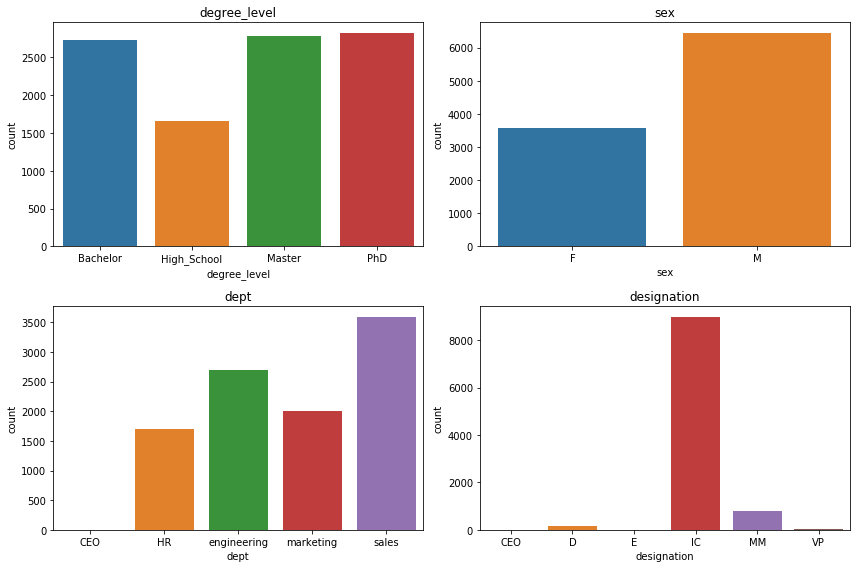

In [0]:
#visualizing categorical data

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
for variable, subplot in zip(categ_cols, ax.flatten()):
    sns.countplot(employee[variable].sort_values(), ax=subplot)
    subplot.title.set_text(variable)
    plt.tight_layout()
    for label in subplot.get_xticklabels():
        label.set_rotation(0)

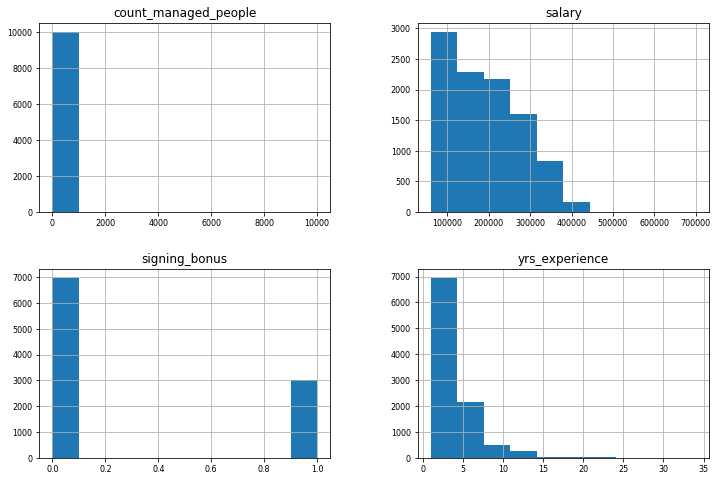

In [0]:
#visualizing numeric data

employee[['signing_bonus', 'salary', 'yrs_experience', 'count_managed_people']].hist(figsize=(12, 8), bins=10, xlabelsize=8, ylabelsize=8); 

Now, since the challenge is on **diversity**, lets visualize the variables only for the **males** data and only for the **female** data and see if we can get some interesting observaations.

In [0]:
#male and female dataframe

male = employee[employee['sex']=='M']
female = employee[employee['sex']=='F']

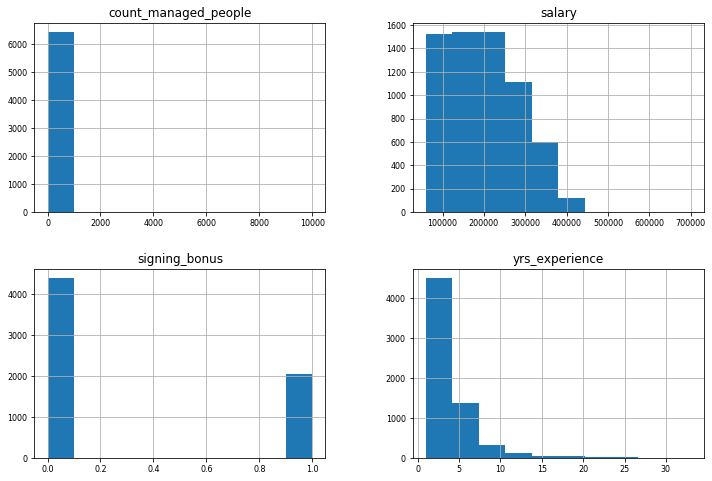

In [0]:
male[['signing_bonus', 'salary', 'yrs_experience', 'count_managed_people']].hist(figsize=(12, 8), bins=10, xlabelsize=8, ylabelsize=8); 

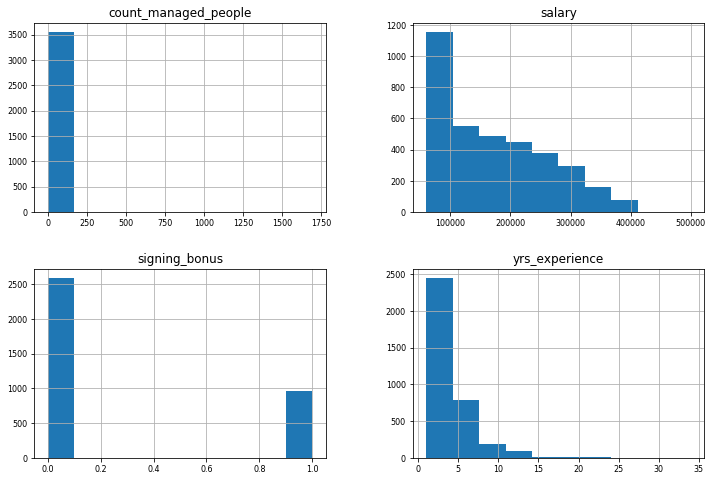

In [0]:
female[['signing_bonus', 'salary', 'yrs_experience', 'count_managed_people']].hist(figsize=(12, 8), bins=10, xlabelsize=8, ylabelsize=8); 

Let us do a side-by-side plot to compare.

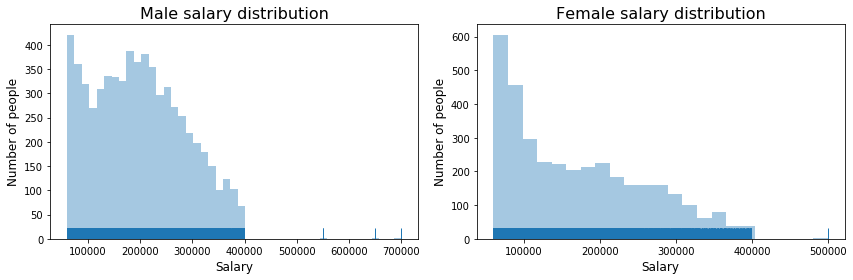

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.distplot(male['salary'], ax=ax[0], kde=False, rug=True)
ax[0].set_xlabel('Salary', fontsize=12)
ax[0].set_ylabel('Number of people', fontsize=12)
ax[0].set_title('Male salary distribution', fontsize=16)

sns.distplot(female['salary'], ax=ax[1], kde=False, rug=True)
ax[1].set_xlabel('Salary', fontsize=12)
ax[1].set_ylabel('Number of people', fontsize=12)
ax[1].set_title('Female salary distribution', fontsize=16)
plt.tight_layout()
plt.show()

Clearly, the viz shows interesting trend that **most of the females in the company get paid around 100,000** while men's salary distribution is a bit constant until %250-300,000

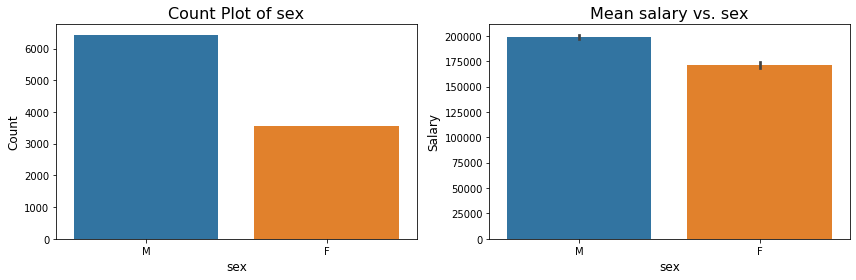

In [0]:
#mean salary vs gender viz

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.countplot(x='sex', data=employee, ax=ax[0])
ax[0].set_xlabel('sex', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of sex', fontsize=16)

sns.barplot(x='sex', y='salary', data=employee, ax=ax[1])
ax[1].set_xlabel('sex', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Mean salary vs. sex', fontsize=16)
plt.tight_layout()
plt.show()

Mean salary of females is about $40,000 less than the males though they might work in different departments. .

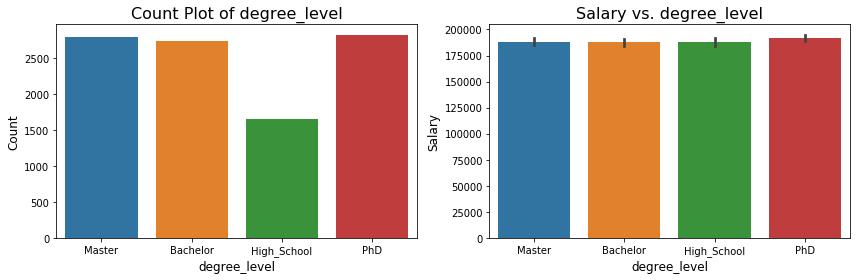

In [0]:
#salary vs degree level

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.countplot(x='degree_level', data=employee, ax=ax[0])
ax[0].set_xlabel('degree_level', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of degree_level', fontsize=16)

sns.barplot(x='degree_level', y='salary', data=employee, ax=ax[1])
ax[1].set_xlabel('degree_level', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. degree_level', fontsize=16)
plt.tight_layout()
plt.show()

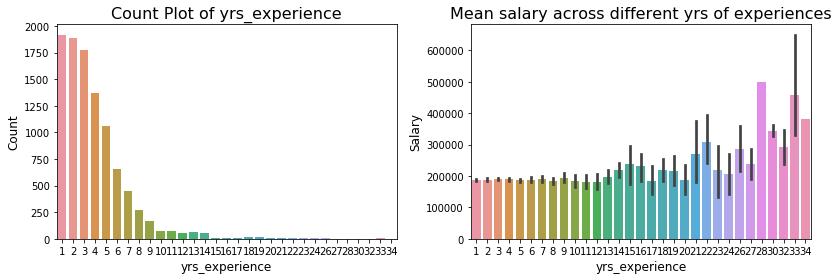

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.countplot(x='yrs_experience', data=employee, ax=ax[0])
ax[0].set_xlabel('yrs_experience', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of yrs_experience', fontsize=16)

sns.barplot(x='yrs_experience', y='salary', data=employee, ax=ax[1])
ax[1].set_xlabel('yrs_experience', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Mean salary across different yrs of experiences', fontsize=16)
plt.tight_layout()
plt.show()

Though, most of the people lie between 0-10 years of experience, mean salary increases after 10 years of experience as seen from the above viz.

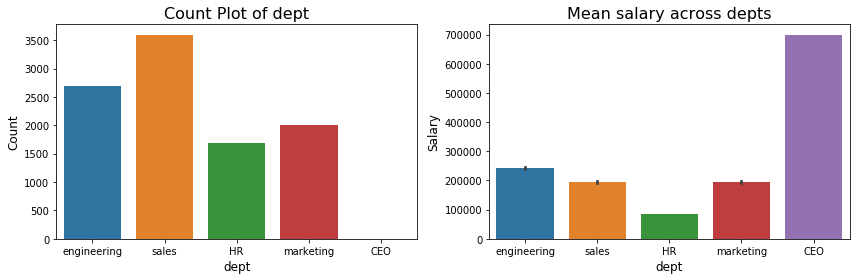

In [0]:
#dept vs salary

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.countplot(x='dept', data=employee, ax=ax[0])
ax[0].set_xlabel('dept', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of dept', fontsize=16)

sns.barplot(x='dept', y='salary', data=employee, ax=ax[1])
ax[1].set_xlabel('dept', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Mean salary across depts', fontsize=16)
plt.tight_layout()
plt.show()

We can see that **HRs have the lowest mean salary** across all departments. Apart from the CEO, Engineers are the highest paid followed by an almost equal pay in sales and marketing. 

Lets now see how the **gender** is distributed across these departments to gain some intuition on diversity and fairness.

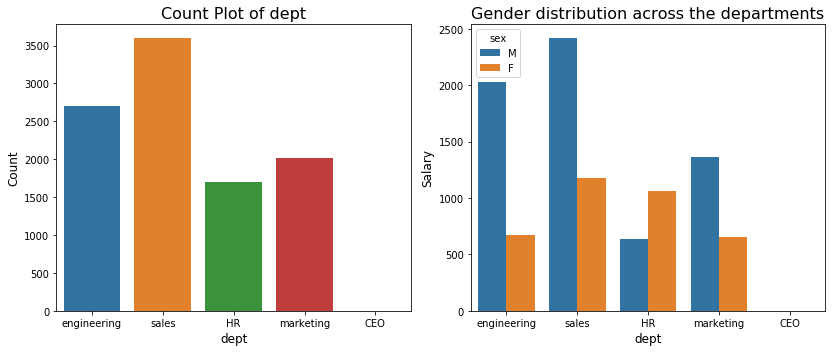

In [0]:
#gender vs dept

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.countplot(x='dept', data=employee, ax=ax[0])
ax[0].set_xlabel('dept', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of dept', fontsize=16)

sns.countplot(x='dept', data=employee, hue = 'sex', ax=ax[1])
ax[1].set_xlabel('dept', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Gender distribution across the departments', fontsize=16)
plt.tight_layout()
plt.show()

**Interesting Trend**

Though the ratio of males to females in the company is 1.8(~2), when we delve into specific departments, we see that:

1) ***In engineering, the ratio of males even increases (as evident from a smaller bar for females)***

2) ***In HR the females lead the males, though we also saw from the previous plot that the HRs are the lowest paid among all the departments.***

There can be several reasons, either HRs are low paid or females are low paid.

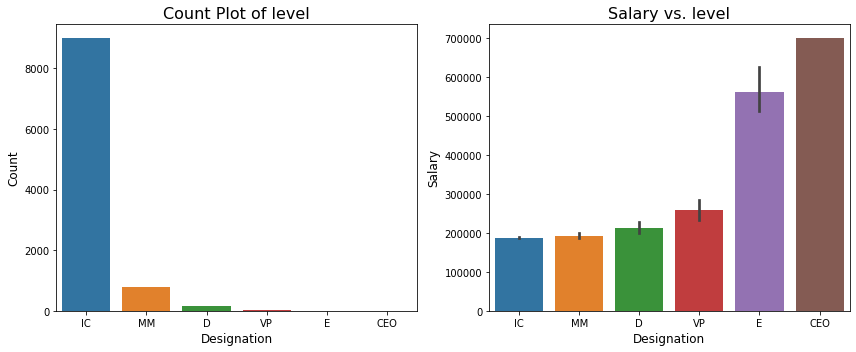

In [0]:
#salary vs level
orders = ['IC', 'MM', 'D', 'VP', 'E', 'CEO']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.countplot(x='designation', data=employee, ax=ax[0], order=orders)
ax[0].set_xlabel('Designation', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of level', fontsize=16)

sns.barplot(x='designation', y='salary', data=employee, ax=ax[1], order=orders)
ax[1].set_xlabel('Designation', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. level', fontsize=16)
plt.tight_layout()
plt.show()

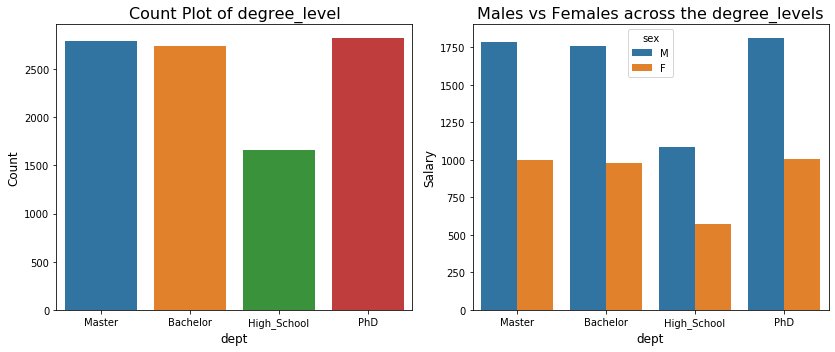

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.countplot(x='degree_level', data=employee, ax=ax[0])
ax[0].set_xlabel('dept', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of degree_level', fontsize=16)

sns.countplot(x='degree_level', data=employee, hue = 'sex', ax=ax[1])
ax[1].set_xlabel('dept', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Males vs Females across the degree_levels', fontsize=16)
plt.tight_layout()
plt.show()

In [0]:
employee.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,designation,count_managed_people
0,138719,0,273000.0,Master,M,2,43602.0,engineering,IC,0
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales,IC,0
2,114657,0,261000.0,Master,F,2,180854.0,sales,IC,0
3,29039,0,86000.0,High_School,F,4,88370.0,HR,IC,0
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales,IC,0


In [0]:
X = employee.copy().drop(columns = ['employee_id', 'salary', 'boss_id'])
y = employee.copy()['salary']

In [0]:
X.dtypes

signing_bonus            int64
degree_level            object
sex                     object
yrs_experience           int64
dept                    object
designation             object
count_managed_people     int64
dtype: object

Now, let's build a **model** to **predict salary**. Using the **model's most imprtant variables** used for predictions, we will get to know about the important factors that affects the salary distribution in the data.

In [0]:
#one hot encoding for categorical variables 

labelencoder = LabelEncoder()
dummy_cols = ['degree_level', 'sex', 'dept', 'designation']
X =  pd.get_dummies(X, columns = dummy_cols)

In [0]:
#splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100,shuffle = True, test_size = 0.25)

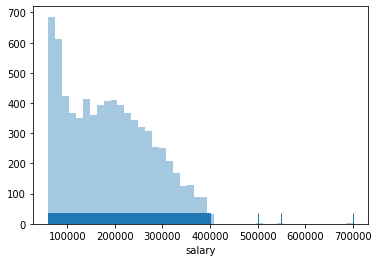

In [0]:
#checking  distribution of y_train ( salary )

sns.distplot(y_train,  kde=False, rug=True)

Since, the distribution is skewed towards the right, lets take a log transformation which will make it easier for the model to predict since the distribution won't be skewed.

In [0]:
#taking log transformations

y_train = np.log(y_train)
y_test = np.log(y_test)

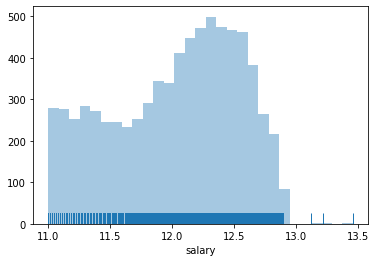

In [0]:
#distribution after transformation

sns.distplot(y_train,  kde=False, rug=True)

In [0]:
#modelling using randomforestregressor

clf = RandomForestRegressor()

# use a full grid over all parameters
param_grid = {'n_estimators' : [50, 100],
              "max_features": [1, 3, 7],
              'max_depth':[3,5,7]
              }

grid = GridSearchCV(clf, param_grid, cv=5,scoring='r2')

grid.fit(X_train, y_train)
print("Grid-Search with r2")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (r2)): {:.3f}".format(grid.best_score_))
#print("feature importances: {:.3f}".format(grid.best_estimator_.feature_importances_))

print(grid.best_estimator_.feature_importances_)

Grid-Search with r2
Best parameters: {'max_depth': 5, 'max_features': 7, 'n_estimators': 50}
Best cross-validation score (r2)): 0.423
[4.88790118e-03 9.00069867e-03 1.35508155e-02 6.66149373e-04
 5.07310829e-04 6.79059909e-04 1.04244870e-03 1.30971103e-02
 1.39376596e-02 5.43022857e-04 6.62454681e-01 1.57442999e-01
 3.86757550e-02 7.72092982e-02 1.16008942e-04 1.52298268e-03
 1.39477263e-03 1.04082219e-03 5.21807088e-04 1.70869660e-03]


In [0]:
clf = RandomForestRegressor(max_depth = 5, max_features = 7, n_estimators = 100 )
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features=7, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_pr=clf.predict(X_test)
#y_pr=clf.predict(X_test)
r2_score(y_test, y_pr)

0.42816660375238835

R2 score is not that great which means there are other factors too which affects the salary. But anyways **0.42 score means the predictors used explain 42% of the variance in salary**. Lets see which are the major contributors in the prediction.

In [0]:

features = list(X_train.columns)
importances = list(clf.feature_importances_)
feature_importances_df = pd.DataFrame({'feature' : features, 'importance' : importances})
feature_importances_df = feature_importances_df.sort_values(by = 'importance', ascending=False)
feature_importances_df = feature_importances_df.iloc[0:10,:].sort_values(by = 'importance', ascending=True)

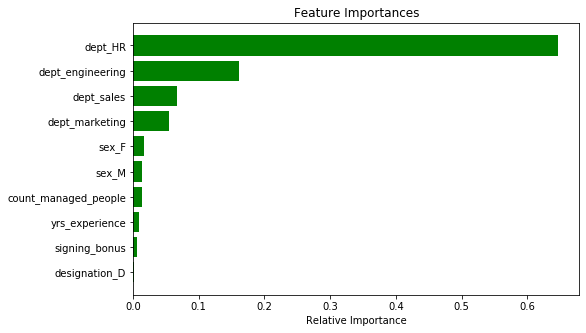

In [0]:
plt.figure(figsize=(8, 5))
plt.title('Feature Importances')
plt.barh(range(0,10), feature_importances_df['importance'], color='green', align='center')
plt.yticks(range(0,10), [i for i in feature_importances_df.feature[0:10]])
plt.xlabel('Relative Importance')
plt.show()

From the random forest, we can see that the most important features that determine the salary are **department** ( whether he/she belongs to HR dept or engineering dept ) and 'gender' though department answers most of the variance in predicting salaries.

Let's visualize an instance of the random forest.

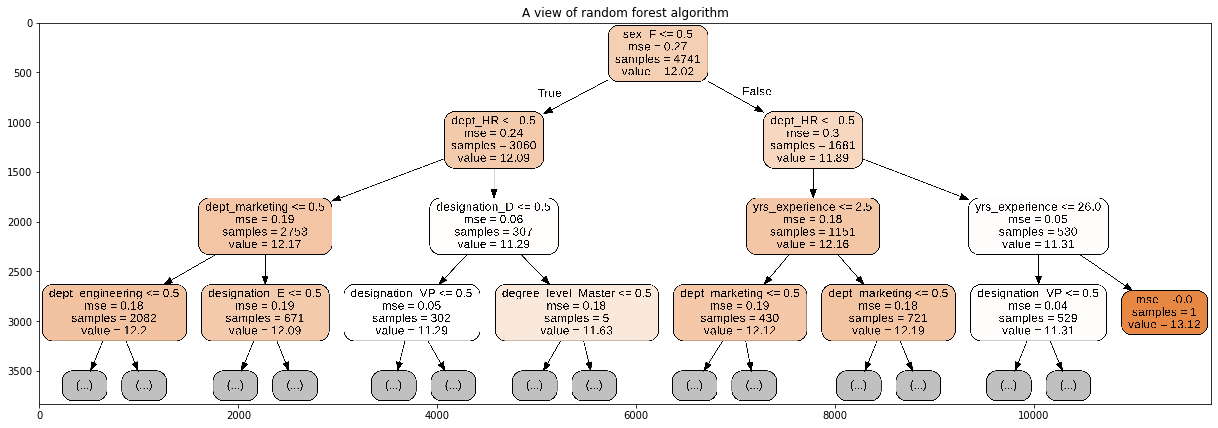

In [0]:
import matplotlib.pyplot as plt
import pydotplus
import matplotlib.image as mpimg
import io
from sklearn import tree


from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz

dot_data = io.StringIO()
estimator = clf.estimators_[70]
tree.export_graphviz(estimator, 
                out_file='tree.dot', max_depth = 3,feature_names = list(X_train.columns),
                rounded = True, proportion = False, 
                precision = 2, filled = True)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
filename = "tree.png"
plt.figure(figsize=(21,16))
plt.title('A view of random forest algorithm')

img = mpimg.imread(filename)
imgplot = plt.imshow(img)

plt.show()

Now, lets find the bias which is the difference in the true and predicted salary and see the trend of bias.

In [0]:
y_predict = clf.predict(X)
y_predict = np.exp(y_predict)

In [0]:
salary_df = pd.DataFrame({'true_salary' :  y , 'predicted_salary' : y_predict, 'bias' :y - y_predict})

In [0]:
salary_df.head()

,true_salary,predicted_salary,bias
0,273000.0,219495.085708,53504.914292
1,301000.0,177236.502907,123763.497093
2,261000.0,178413.926729,82586.073271
3,86000.0,82596.375560,3403.624440
4,126000.0,178512.811692,-52512.811692


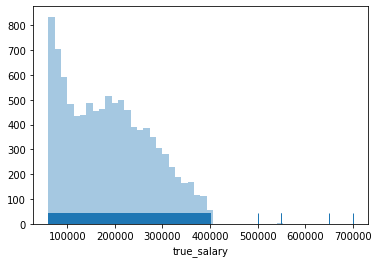

In [0]:
sns.distplot(salary_df['true_salary'],  kde=False, rug=True)

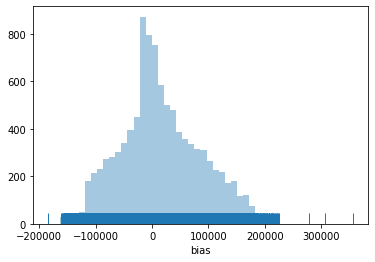

In [0]:
sns.distplot(salary_df['bias'],  kde=False, rug=True)

We can see that the predicted values' **bias is almost normally distributed**. Now, let us use the model to predict on all the 10000 employees and lets plot it vs Bias to see the trend.

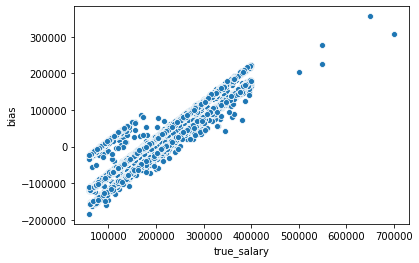

In [0]:
ax = sns.scatterplot(x='true_salary', y='bias', data=salary_df)

Clearly, the **higher the salary is**, the **more is the bias towards the positive scale**. This means that when salary grows higher for an individual, the actual salary is a lot more than what our generalized model is predicting. This means that people with higher salaries are generally overpaid.

Also, we saw while visualizing our data that there is a bias in diversity because though females form about 35% of the employees,they aren't equally represented acorss departments. **The ratio is less in engineering department and infact females lead in the HR department where the mean salary is lower than the mean salary for any other department.**

**My suggestion to the head of HR will be to hire more females in engineering and males in HR. Though females have a major representation in HR, they aren't really hiring much for engineering. This will ensure more diversity in creativity and innovation for the company.**

**Also, I will suggest capping salaries at various levels since people with higher salaries are generally overpaid it seems.**


Thank you